## Import TensorFlow and other libraries

In [2]:
# !pip install tensorflow==2.2.0t
!pip install matplotlib
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

Matplotlib is building the font cache; this may take a moment.


In [5]:
# pip install tensorflow

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
tf.__version__

'2.2.0'

In [20]:
PATH = r'C:/Users/rama/Desktop/Project/colab'
print('Path:',PATH)

Path: C:/Users/rama/Desktop/Project/colab


In [21]:
print(os.listdir(PATH+'/train'))

['.DS_Store', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '109.png', '110.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '147.png', '149.png', '15.png', '150.png', '151.png', '152.png', '154.png', '157.png', '159.png', '16.png', '160.png', '162.png', '167.png', '169.png', '17.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '18.png', '180.png', '183.png', '184.png', '185.png', '186.png', '187.png', '188.png', '189.png', '191.png', '193.png', '194.png', '195.png', '196.png', '198.png', '199.png', '2.png', '200.png', '201.png', '202.png', '203.png', '204.png', '206.png', '207.p

In [22]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [23]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

(400, 300, 3)


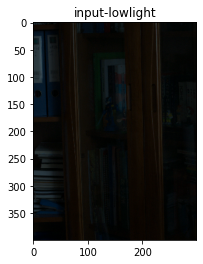

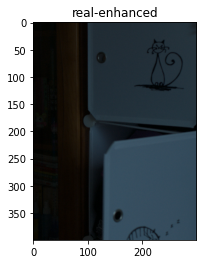

In [26]:
inp, re = load(PATH+'/train/2.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.title('input-lowlight')
plt.imshow(inp/255.0)
plt.figure()
plt.title('real-enhanced')
plt.imshow(re/255.0)
print(inp.shape)

In [27]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [28]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [29]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [30]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)
  print(input_image.shape)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)
  print('crop',input_image.shape)
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

(286, 286, 3)
crop (256, 256, 3)


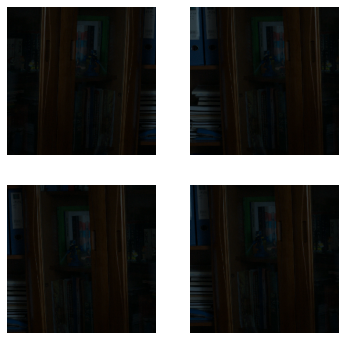

In [31]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [32]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [33]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Input Pipeline

In [36]:
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

(286, 286, None)
crop (256, 256, 3)


In [37]:
test_dataset = tf.data.Dataset.list_files(PATH+'/test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator

In [38]:
OUTPUT_CHANNELS = 3

In [39]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [40]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 200, 150, 3)


In [41]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [42]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 400, 300, 3)


In [43]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [64]:
!pip install pydot
!pip install graphviz
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [73]:
gen_output = [[1., 3.],[3., 7.]]#generator(inp[tf.newaxis,...], training=True)
# plt.imshow(gen_output[0,...])

In [74]:
LAMBDA = 30

In [75]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


In [76]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [77]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [87]:
# disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
# plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

In [88]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [89]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [90]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [91]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [92]:
from math import log10, sqrt 
import cv2 
import numpy as np 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [93]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  value = PSNR(tar[0], prediction[0]) 
  print(f"PSNR value is {value} dB") 

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

PSNR value is 50.12815724417777 dB


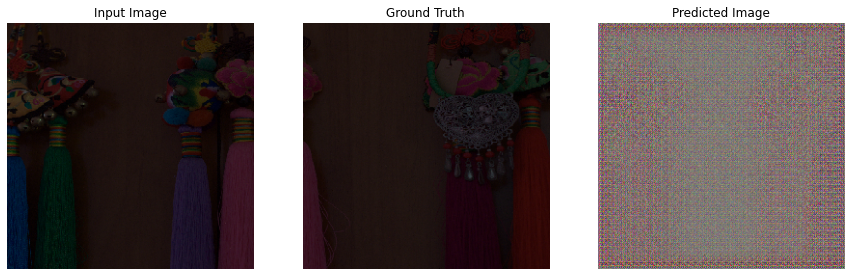

In [94]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [95]:
EPOCHS = 25

In [96]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [97]:
import sys

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

  return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [98]:
from tensorflow.keras.models import Sequential, save_model, load_model

In [99]:
filepath = './saved_model'

In [100]:
def fit(train_ds, epochs, test_ds):
  g_t_loss = []
  g_g_loss = []
  g_l1_loss = []
  d_loss = []
  
  for epoch in range(epochs):
    start = time.time()

    #display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch+1)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, epoch)
      gen_total_loss_last = float(gen_total_loss)
      gen_gan_loss_last = float(gen_gan_loss) 
      gen_l1_loss_last = float(gen_l1_loss)
      disc_loss_last = float(disc_loss)
    print()
    print(f"gen_total_loss : {gen_total_loss_last}, gen_gan_loss : {gen_gan_loss_last}, gen_l1_loss : {gen_l1_loss_last}, disc_loss : {disc_loss_last}")

    g_t_loss.append(gen_total_loss_last)
    g_g_loss.append(gen_gan_loss_last)
    g_l1_loss.append(gen_l1_loss_last)
    d_loss.append(disc_loss_last)


    # saving (checkpoint) the model every 20 epochs
    # if (epoch + 1) % 50 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  # checkpoint.save(file_prefix = checkpoint_prefix)

  return g_t_loss, g_g_loss, g_l1_loss, d_loss

In [101]:
#docs_infra: no_execute
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Now run the training loop:

PSNR value is 49.366363327951746 dB


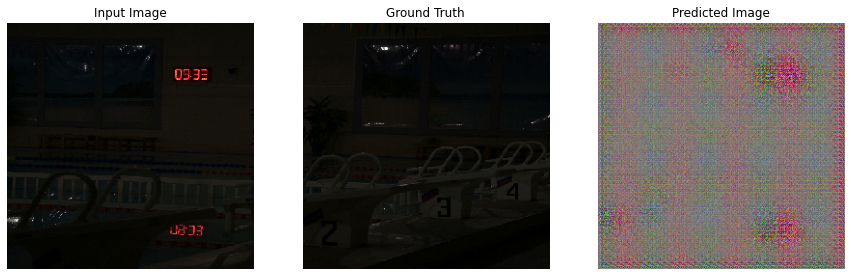

Epoch:  1
....................................................................................................
..............................................................

In [ ]:
g_t_loss, g_g_loss, g_l1_loss, d_loss = fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
import pandas as pd
import numpy as np

losses = pd.DataFrame(list(zip(g_t_loss, g_g_loss, g_l1_loss, d_loss)), columns=['g_t_loss', 'g_g_loss', 'g_l1_loss', 'd_loss'])
losses

In [ ]:
e = np.arange(1,26)
plt.figure(figsize=(25,8))
plt.subplot(4,1,1)
plt.plot(e, g_t_loss)
plt.title("Total Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(4,1,2)
plt.plot(e, g_l1_loss)
plt.title("Generator l1 (MAE) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(4,1,3)
plt.plot(e, g_g_loss)
plt.title("Generator GAN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(4,1,4)
plt.plot(e, d_loss)
plt.title("Total Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show

## Generate using test dataset

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)